# Команда: Бета Банк


**Цель:** Создать CLTV модель, которая будет выдавать вероятности перехода в каждый из 17 продуктовых кластеров в течение 12 месяцев.

Альфа-Банком предоставлены следующие **данные**:

-   Тренировочный датасет `train_data.pqt` содержит данные о 200 000 клиентах банка и их целевых переменных за три последовательных месяца (month_1, month_2, month_3)
-   Тестовый датасет `test_data.pqt` записи о 100 000 клиентах за 3 последовательных месяца (month_4, month_5, month_6)
   
-   Продуктовый кластер, в котором клиент будет находится через год - `end_cluster`. Необходимо получить вероятности перехода клиента в продуктовые кластеры для последнего месяца (month_6).

  
-    Метрикой качества выступает **ROC-AUC**.

Данные о клиентах и масскированы.

## Подключение модулей

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.9 MB/s eta 0:00:00


In [2]:
# работа с ОС
import os
import warnings
import time
from google.colab import drive
# работа с данными
import json
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.ticker import MaxNLocator
# работа с ML
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# модели машинного обучения
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
# обработка ошибок
from pyarrow import ArrowInvalid
# настройка среды выполнения
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка и изучение данных

In [8]:
def open_df(filepath: str) -> Optional[pd.DataFrame]:
    """
    Функция для чтения датасета по указанному пути

    args:
    filepath (str) - путь к файлу .pqt / .parquet

    return:
    датасет в формате pd.DataFrame, если найден файл по указанному пути
    """
    if os.path.exists(filepath):
        try:
            result: pd.DataFrame = pd.read_parquet(filepath, engine='auto')
            print(f"Файл {filepath} успешно открыт")
            return result
        except ArrowInvalid:
            print("Неверный тип файла. Поддерживаемый - .pqt или .parquet")
            return
    print(f"Файл не найден по пути {filepath}")
    return

In [9]:
# # Путь до файла train_df
# path_train_df = "/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/train_data.pqt"
# # Путь до файла test_df
# path_test_df = "/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/test_data.pqt"
# Путь до файла train_df
path_train_df = "/content/drive/MyDrive/train_data.pqt"
# Путь до файла test_df
path_test_df = "/content/drive/MyDrive/test_data.pqt"
# открытие файлов
train_df = open_df(path_train_df)
test_df = open_df(path_test_df)
# объединение файлов
df = pd.concat([train_df, test_df], ignore_index=True)

display(train_df.head(2))
display(test_df.head(2))

Файл /content/drive/MyDrive/train_data.pqt успешно открыт
Файл /content/drive/MyDrive/test_data.pqt успешно открыт


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.0962,0.3355,-0.1260,-0.0956,channel_code_12,city_14,city_type_0,None,...,0.0110,0.9461,0.4078,-0.1540,0.5489,0.5410,0.0317,0.2573,0.5614,{α}
1,200000,month_5,-0.0243,-0.0598,-0.1243,-0.0234,channel_code_12,city_14,city_type_0,None,...,0.0068,0.9453,0.3963,-0.1505,0.5495,0.5521,0.2378,0.2642,0.7152,{α}


### Описание признаков

In [16]:
# feature_description = pd.read_excel("/content/drive/MyDrive/feature_description.xlsx")
# feature_description.columns = ['col_name', 'description', 'type']
# feature_description

,col_name,description,type
0,start_cluster,Стартовый кластер клиента,category
1,balance_amt_avg,Среднемесячный остаток на счетах клиента за месяц,number
2,balance_amt_max,Максимальный остаток на счетах клиента за месяц,number
3,balance_amt_min,Минимальный остаток на счетах клиента за месяц,number
4,balance_amt_day_avg,Среднедневной остаток на счетах клиента за месяц,number
5,channel_code,"Символьный код канала продаж, через который кл...",category
6,city,Населенный пункт,category
7,city_type,Тип населенного пункта,category
8,index_city_code,Код города в почтовом индексе,category
9,ogrn_days_end_month,Количество дней с момента регистрации ОГРН до ...,number


### Базовый анализ данных

In [11]:
print(f"Количество записей в тренировочных данных: {len(train_df)}")
print(f"Количество записей в тестовых данных: {len(test_df)}")

Количество записей в тренировочных данных: 600000
Количество записей в тестовых данных: 290120


Реальное количество записей в тестовых данных не делится на 3, следовательно есть дисбаланс по месяцам.

In [14]:
df.dtypes.value_counts()

float64    81
object     11
int64       1
Name: count, dtype: int64

Признаки по большей части представляют собой числа с плавающей точкой, также присутствует 11 категориальных признаков, их необходимо закодировать.

In [15]:
df.duplicated(keep='first').sum()

0

Дубликаты записей отсутствуют.

In [17]:
df['start_cluster'].value_counts()

start_cluster
{α}          491192
{}           107072
{α, η}        57458
{α, γ}        43129
{other}       42545
{α, β}        13498
{α, δ}        11350
{α, ε}         7464
{α, θ}         6348
{α, ψ}         3876
{α, μ}         1883
{α, ε, η}      1620
{α, ε, θ}      1083
{α, λ}          997
{α, ε, ψ}       462
{λ}             114
{α, π}           29
Name: count, dtype: int64

Распределение основного признака (начального кластера, из которого будет осуществляться переход в конечный кластер, являющийся целевой переменной) сильно дизбалансное.

### Пропущенные значения в признаках

In [ ]:
def plt_null_df(df: pd.DataFrame) -> None:
    """
    Функция построение графика пропущенных значений в признаках

    args:
    df (pd.DataFrame) - датафрейм с рассматриваемыми признаками

    return:
    Функция строит график без возврата результата
    """
    plt.figure(figsize=(30, 18))
    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")
    # указание признаков в качестве отметок на оси абсцисс
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    # имена осей
    plt.xlabel("Признак")
    plt.ylabel("Количество пропущенных значений (жёлтый)")
    # визуализация графика
    plt.show()

In [21]:
df.isna().sum()

id                              0
date                            0
balance_amt_avg             95060
balance_amt_max             95060
balance_amt_min             95060
balance_amt_day_avg         95060
channel_code                62878
city                       138956
city_type                  139336
index_city_code            481685
ogrn_days_end_month         45751
ogrn_days_end_quarter       45751
ogrn_month                  45751
ogrn_year                   45751
ft_registration_date        46198
max_founderpres            496784
min_founderpres            496784
ogrn_exist_months           45751
okved                       46372
segment                     44171
sum_of_paym_2m             222345
sum_of_paym_6m             222345
sum_of_paym_1y             222345
sum_a_oper_1m                   0
cnt_a_oper_1m              291391
sum_b_oper_1m                   0
cnt_b_oper_1m              291391
sum_c_oper_1m                   0
cnt_c_oper_1m              291391
sum_deb_d_oper

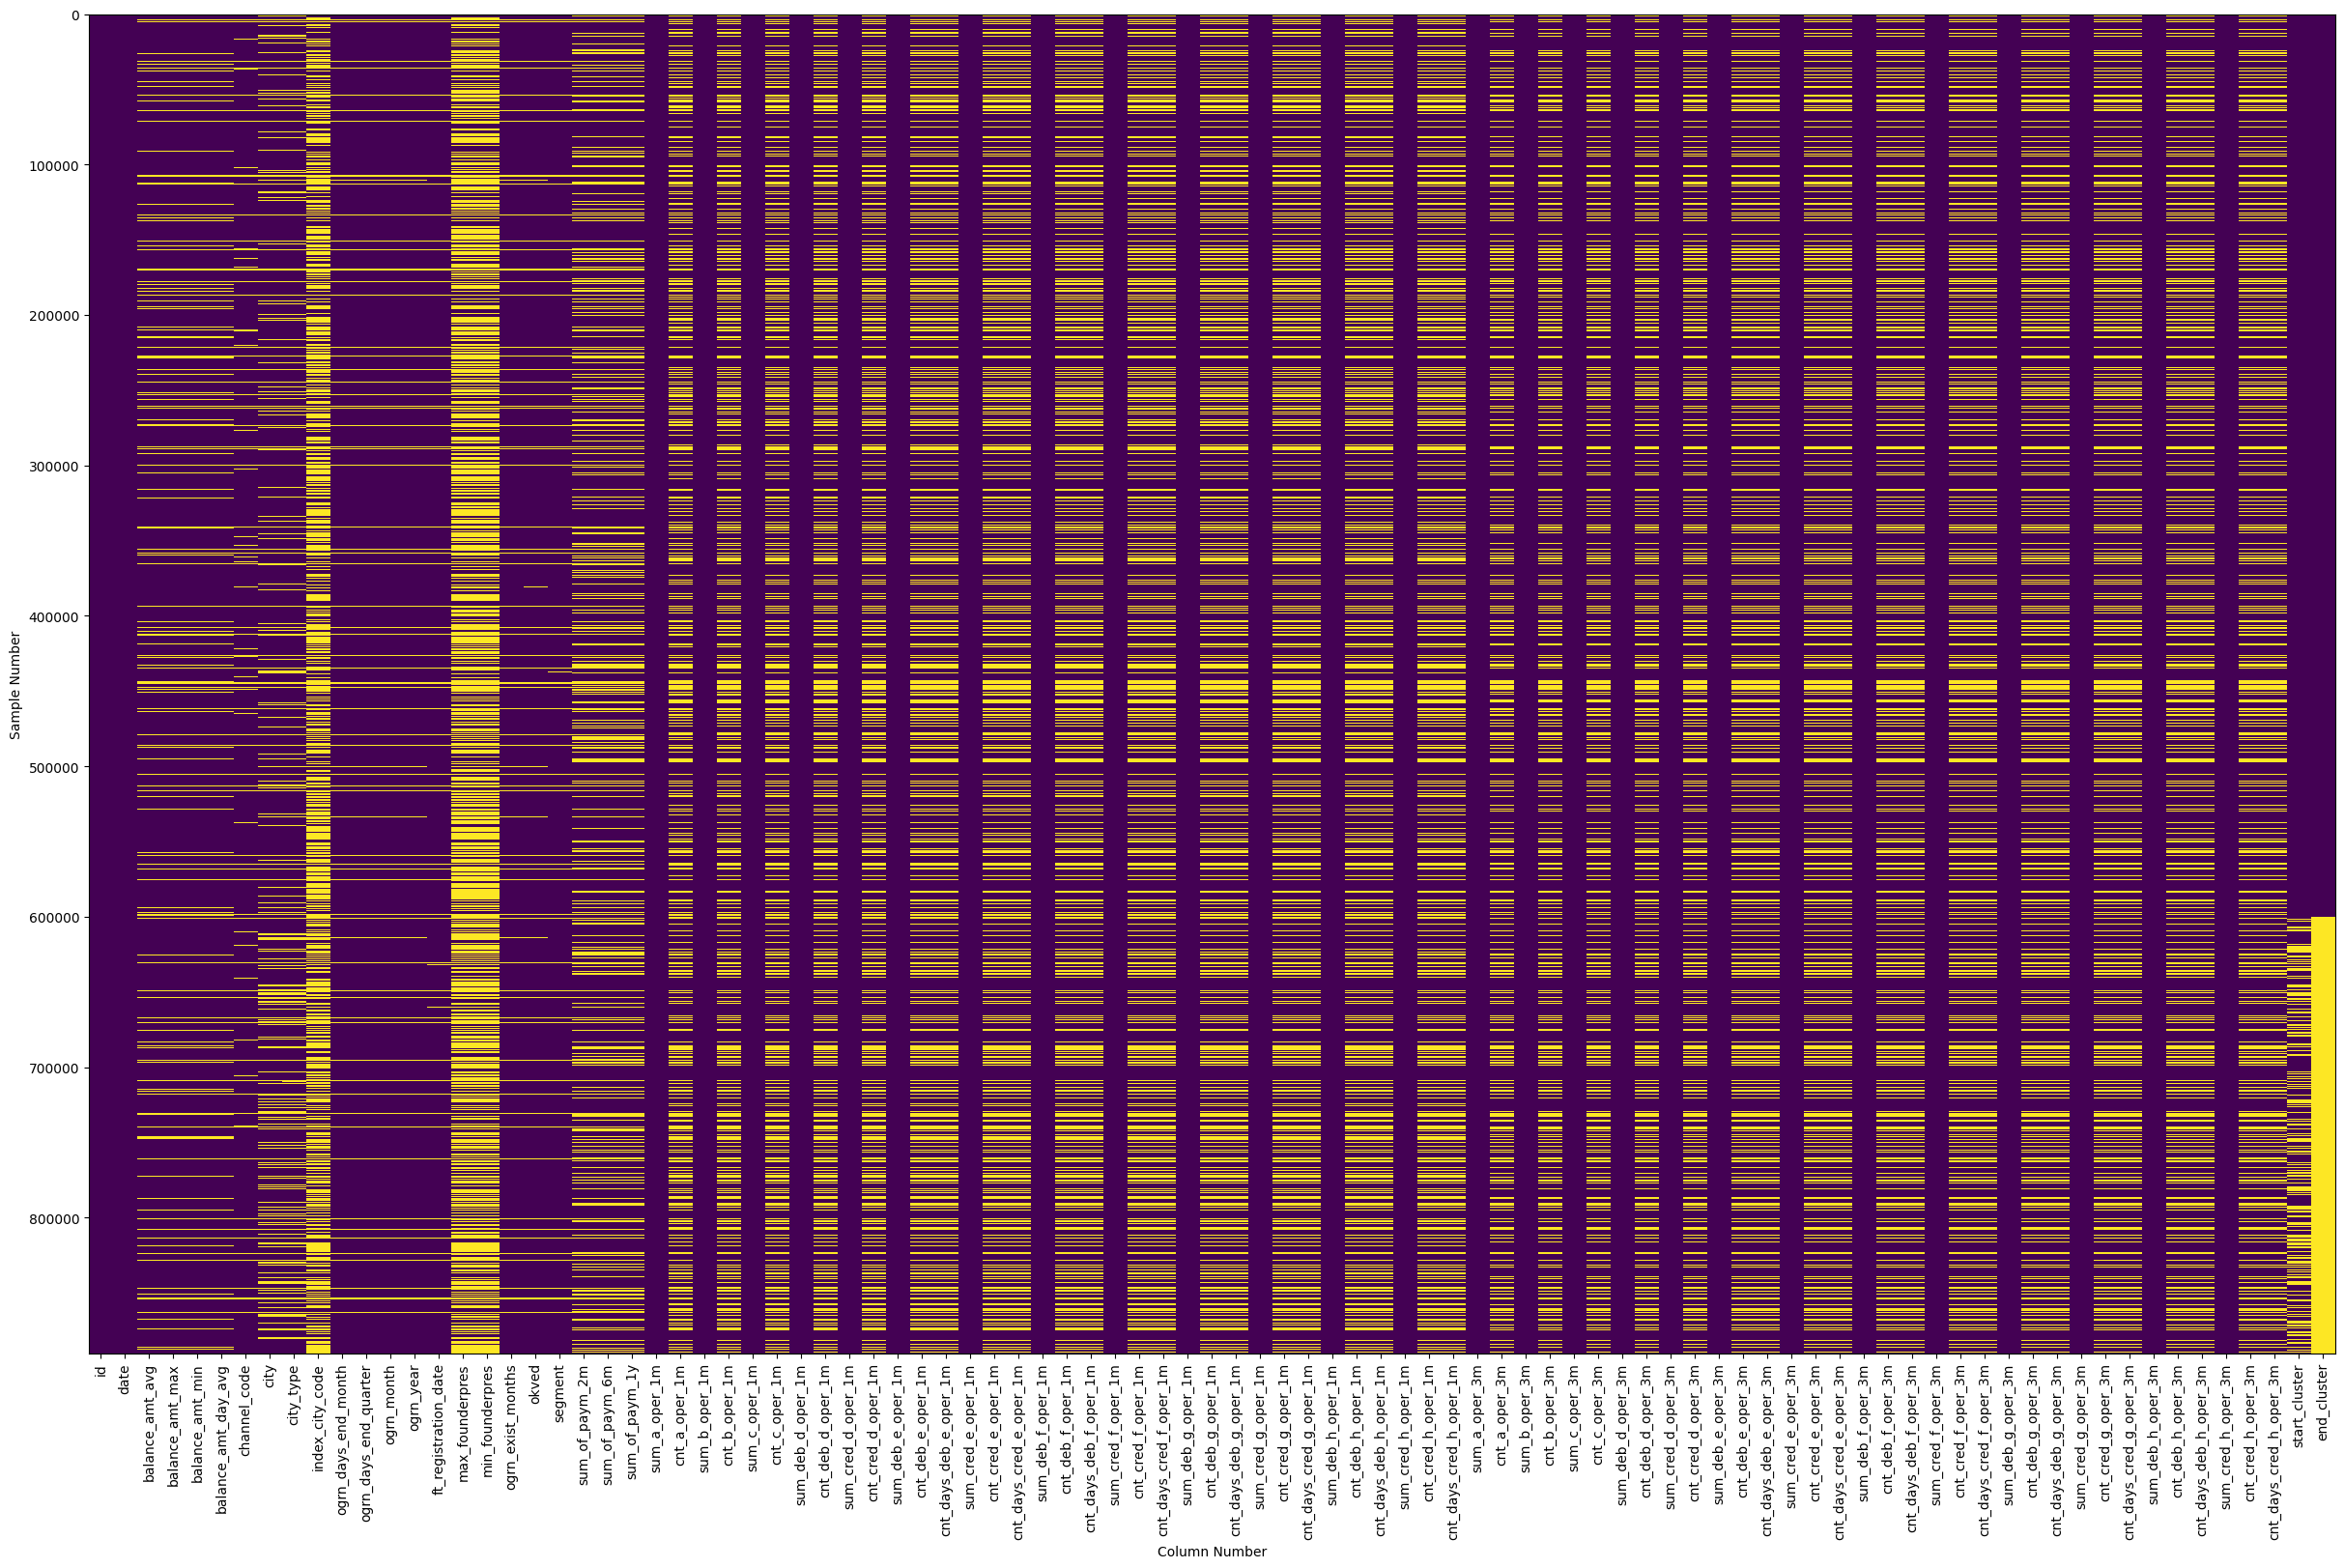

In [ ]:
plt_null_df(df.isna())

Большое количество пропущенных данных, которые необходимо восстановить для увеличения точности модели.
- Заметно, что последний месяц (month_6) признака start_cluster, для которого отсутствует end_cluster имеет почти половину пропущенных значений. Их необходимо восстановить алгоритмически или с помощью модели ML.

### Уникальных значения признаков

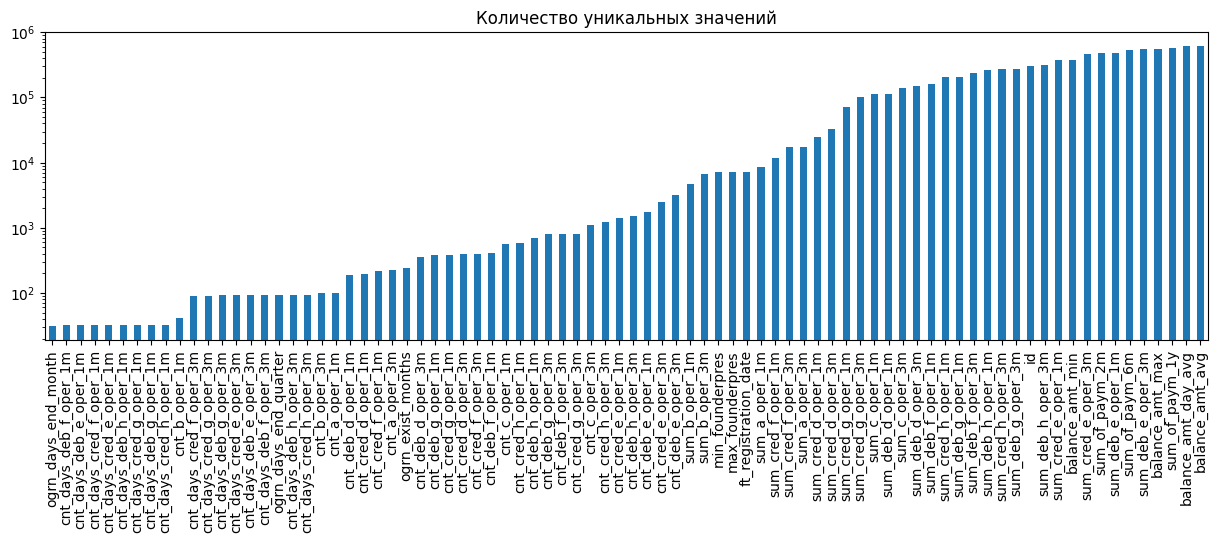

In [18]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Количество уникальных значений");

### Корреляция признаков

In [19]:
def visualize_corr(data: pd.DataFrame) -> None:
    """
    Функция построение тепловой карты корреляции признаков

    args:
    data (pd.DataFrame) - датафрейм с рассматриваемыми признаками=

    return:
    Функция строит график без возврата результата
    """
    num_type_corr_train = data.select_dtypes(include='number').corr()
    # получение значений ниже главной диагонали матрицы
    mask = np.triu(num_type_corr_train, 1)
    plt.figure(figsize=(20, 15))
    dataplot = sns.heatmap(num_type_corr_train, mask=mask,
                           cmap="YlGnBu", annot=True, fmt=".1f",
                           annot_kws={'size': 5})
    # установление максимального количества отображаемых признаков
    dataplot.xaxis.set_major_locator(MaxNLocator(len(num_type_corr_train.columns)))
    dataplot.yaxis.set_major_locator(MaxNLocator(len(num_type_corr_train.columns)))
    # указание значений по абсциссе и ординате
    dataplot.set_xticklabels(num_type_corr_train.columns, rotation=90, fontsize=7)
    dataplot.set_yticklabels(num_type_corr_train.columns, rotation=0, fontsize=7)
    # отображение графика
    plt.show()

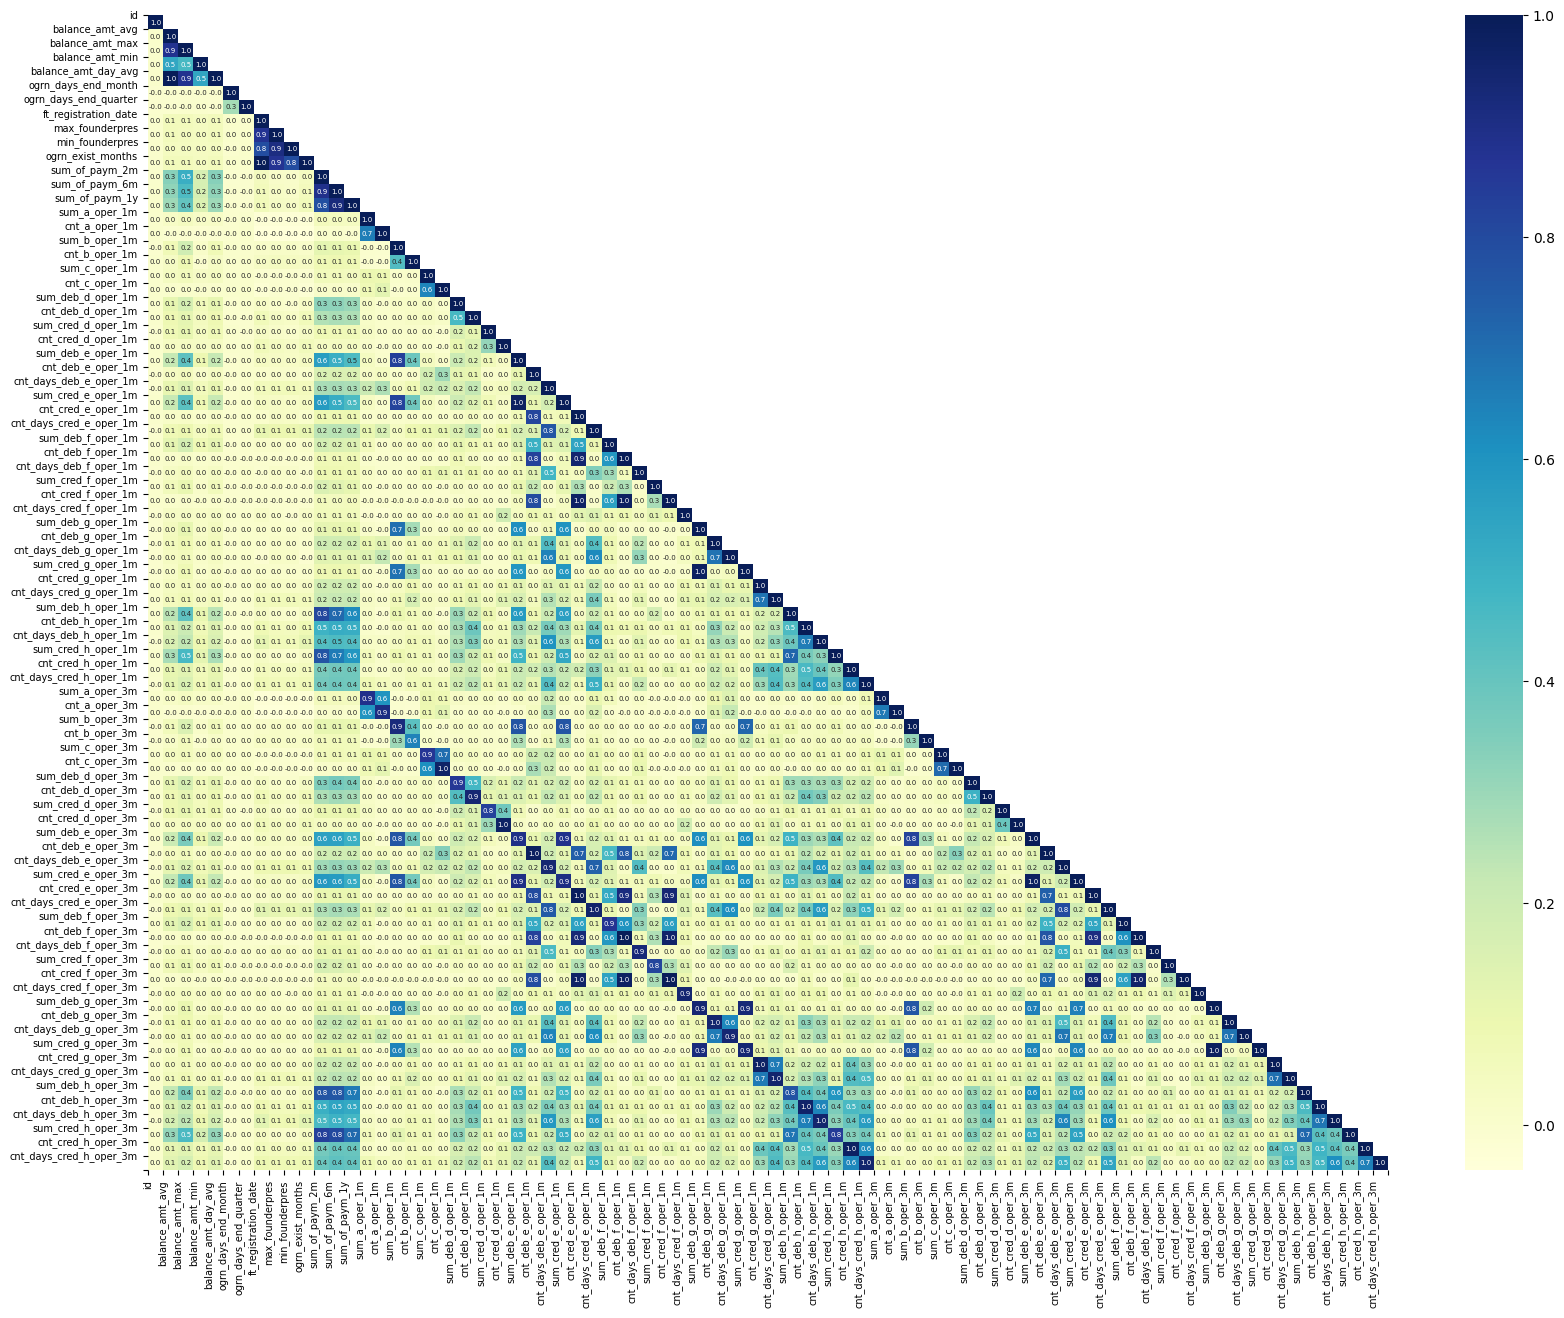

In [20]:
visualize_corr(train_df)

Некоторые признаки коррелируют между собой с уровнем корреляции > 90%.

## Feature engineering


### Восстановление численных признаков

Признаки, описывающие статистические показатели определённой операции можно обобщить с помощью признаков "общей суммы" операций и "количества" операций. Это введёт дополнительный признак для улучшения качества модели.

In [ ]:
# отбор только численных признаков
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    # получением минимального возможного значения признака
    min_val = df[col].min()
    # заполнение пропущенных значений минимальным значением признака
    df[col].fillna(min_val, inplace=True)

Для начала были восстановленны пропущенные записи у всех численных признаков минимальными значениями признака.

In [ ]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

Введение дополнительного признака "среднего" по каждой операции каждого клиента за каждый месяц.

### Восстановление категориальных данных

Стоит предположить малую вероятность того, что кластер клиента за ближайшие месяцы поменяется:

In [8]:
# группировка по клиентам в тренировочных данных
same_sc_train = train_df.groupby(by=['id'])
# количество клиентов, не поменявших start_cluster с 1 по 3 месяцы
same_sc_train = same_sc_train.apply(lambda x: len(set(x['start_cluster'])) == 1)
# процент клиентов, не поменявших start_cluster с 1 по 3 месяцы
same_sc_train = round(same_sc_train.sum() / same_sc_train.count() * 100, 2)
# группировка по клиентам в тестовых данных для 4 и 5 месяцев (без пропусков)
same_sc_test = test_df[test_df['date'].isin(['month_4', 'month_5'])]
same_sc_test = same_sc_test.groupby(by=['id'])
# количество клиентов, не поменявших start_cluster с 4 по 5 месяцы
same_sc_test = same_sc_test.apply(lambda x: len(set(x['start_cluster'])) == 1)
# процент клиентов, не поменявших start_cluster с 4 по 5 месяцы
same_sc_test = round(same_sc_test.sum() / same_sc_test.count() * 100, 2)
print(f"Шанс, что клиент остаётся в том же кластере с 1 по 3 месяц: {same_sc_train}%")
print(f"Шанс, что клиент остаётся в том же кластере с 4 по 5 месяц: {same_sc_test}%")

Шанс, что клиент остаётся в том же кластере с 1 по 3 месяц: 80.04%
Шанс, что клиент остаётся в том же кластере с 4 по 5 месяц: 93.3%


Отсюда следует, что пропущенные категориальные признаки можно восстановить последним значеним признака для клиента.

In [ ]:
def restore_cal(x: pd.Series) -> pd.Series:
    """
    Функция восстановления категориального признака последним значением для
    конкретного клиента

    args:
    x (pd.Series) - значения рассматриваемого признака в группе

    return:
    Возвращается группа с восстановленным пропущенным значением
    """
    # если есть пропущеные значения
    if x.isna().any() and not x.isna().all():
        # заполняем пропущенное значение последним в группе
      return x.fillna(x.dropna().iloc[-1])
    # если нет пропусков, возвращаем исходную группу
    return x

In [ ]:
cat_columns_to_restore = ['channel_code', 'city', 'city_type', 'ogrn_month',
                          'ogrn_year', 'okved', 'segment']

for column in cat_columns_to_restore:
  df[column] = df.groupby('id')[column].apply(
      lambda x: restore_cal(x)).reset_index()[column]
  print(f"Колонка - {column} - восстановлена")

Колонка - channel_code - восстановлена
Колонка - city - восстановлена
Колонка - city_type - восстановлена
Колонка - ogrn_month - восстановлена
Колонка - ogrn_year - восстановлена
Колонка - okved - восстановлена
Колонка - segment - восстановлена


Сохраняем частично восстановленный датасет:

In [ ]:
df.to_parquet("df_after_cat_restore_fill_min.pqt")

In [ ]:
# path_df = "/kaggle/input/alfa-hackaton/df.pqt"
path_df = "df_after_cat_restore_fill_min.pqt"
df = open_df(path_df)

In [ ]:
cat_cols = [
          "channel_code", "city", "city_type", "okved", "segment",
          "start_cluster", "ogrn_month", "ogrn_year",
      ]
df['date'] = df['date'].replace({'month_4': 'month_1',
                                 'month_5': 'month_2',
                                 'month_6': 'month_3'})
df[cat_cols] = df[cat_cols].astype("object")

### Создание таблицы с 3 месяцами

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "ogrn_month", "ogrn_year",
]
cat_cols_month_1 = [f'{col}_month_1' for col in cat_cols]
cat_cols_month_2 = [f'{col}_month_2' for col in cat_cols]
# сводная таблица по клиентам и месяцам
pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'] + cat_cols_month_1 + cat_cols_month_2,
    axis=0)
categorical_columns = pivot_df.select_dtypes(include=['object']).columns
# заполняем пропущенные элементы новой категорией
pivot_df[categorical_columns] = pivot_df[categorical_columns].fillna("missing")

In [ ]:
# получение только численных признаков
numeric_cols = pivot_df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    # получением минимального возможного значения признака
    min_val = pivot_df[col].min()
    # заполнение пропущенных значений минимальным значением признака
    pivot_df[col].fillna(min_val, inplace=True)

In [ ]:
def remove_outliers(df: pd.DataFrame, k: float = 1.5) -> pd.DataFrame:
    """
    Функция получения границ выбросов признака и замены выбросов граничными
    значениями

    args:
    df (pd.DataFrame) - рассматриваемый датафрейм
    k (float) - множитель для определения границ выбросов. Чем больше k,
    тем более "мягким" будет определение выбросов, и наоборот

    return:
    Возвращается датасет с заменёнными выбросами на граничные значения
    """
    # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
    df_cleaned = df.copy()

    # Итерируемся по каждому числовому столбцу
    for column in df_cleaned.select_dtypes(include='number').columns:
        # Вычисляем квартили
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        # Вычисляем межквартильный размах (IQR)
        IQR = Q3 - Q1
        # Определяем верхнюю и нижнюю границы для выбросов
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        # Заменяем значения за пределами границ на минимальное и максимальное значение
        df_cleaned[column] = df_cleaned[column].clip(
            lower=lower_bound, upper=upper_bound)
    return df_cleaned

# Применяем функцию к DataFrame, чтобы избавиться от выбросов
df = remove_outliers(df)

In [ ]:
df = pivot_df  # ??????????

### Восстановление start_claster с помощью ML

In [ ]:
# выделяем тренировочные данные (без пропущенных значений целевой переменной)
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)
# выделяем тестовые данные (пропущенные значения целевой переменной)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)
# получаем признаки для обучения и целевую переменную
X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']
# разбиваем на подвыборки обучения и тестирования 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

#### Обучение CATBOOST

In [3]:
# архитектура модели
catboost_model_start_cluster = CatBoostClassifier(
    iterations=1024,            # кол-во итераций обучения
    depth=6,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
                                # отстутсвия изменения ф. ошибки 20 итераций
    )

In [ ]:
def train_catboost(model: CatBoostClassifier,
                   x_train: pd.DataFrame, y_train: pd.Series,
                   x_val: pd.DataFrame, y_val: pd.Series,
                   cat_names: pd.core.indexes.base.Index,
                   model_name: str,
                   verbose_step: int = 100) -> pd.DataFrame:
    """
    Функция обучения, тестирования и сохранения модели catboost

    args:
    model (CatBoostClassifier) - модель catboost
    x_train (pd.DataFrame) - датафрейм для обучения
    y_train (pd.Series) - целевая переменная в обучении
    x_val (pd.DataFrame) - датафрейм для тестирования точности модели
    y_train (pd.Series) - целевая переменная в тестировании
    cat_names (pd.core.indexes.base.Index) - список категориальных признаков
    из тренировочного и тестового датафреймов для автоматической предобработки
    самой моделью
    model_name (str) - имя модели для сохранения
    verbose_step (int) - шаг вывода статуса модели

    return:
    Возвращается важность признаков модели
    """
    model.fit(
        x_train, y_train,                   # обучающая выборка
        cat_features=np.array(cat_names),   # категориальные признаки
        eval_set=(x_val, y_val),            # тестовая выборка
        verbose=verbose_step                         # шаг вывода статуса модели
    )
    # сохранение модели
    model.save_model(f'{model_name}.json')
    # получение важности признаков
    feature_importance = model.get_feature_importance(prettified=True)
    return feature_importance

In [ ]:
# получаем список категориальных признаков
cat_names = X.select_dtypes(include=['object']).columns
# обучение модели с получением важности признаков
feature_importance = train_catboost(
    catboost_model_start_cluster, X_train, y_train, X_val, y_val, cat_names,
    'catboost_model_start_cluster')

0:	learn: 1.9046574	test: 1.8921863	best: 1.8921863 (0)	total: 171ms	remaining: 2m 55s
100:	learn: 0.2462372	test: 0.2282238	best: 0.2282238 (100)	total: 9.49s	remaining: 1m 26s
200:	learn: 0.2284146	test: 0.2165372	best: 0.2165372 (200)	total: 17.8s	remaining: 1m 12s
300:	learn: 0.2229305	test: 0.2136191	best: 0.2136191 (300)	total: 25.6s	remaining: 1m 1s
400:	learn: 0.2189092	test: 0.2118640	best: 0.2118640 (400)	total: 33.3s	remaining: 51.8s
500:	learn: 0.2152533	test: 0.2104368	best: 0.2104275 (499)	total: 41.2s	remaining: 43s
600:	learn: 0.2120252	test: 0.2094955	best: 0.2094902 (598)	total: 49.1s	remaining: 34.6s
700:	learn: 0.2091849	test: 0.2086726	best: 0.2086726 (700)	total: 57s	remaining: 26.3s
800:	learn: 0.2062694	test: 0.2078413	best: 0.2078413 (800)	total: 1m 4s	remaining: 18.1s
900:	learn: 0.2039188	test: 0.2071472	best: 0.2071437 (897)	total: 1m 12s	remaining: 9.95s
1000:	learn: 0.2013223	test: 0.2065626	best: 0.2065602 (999)	total: 1m 20s	remaining: 1.86s
1023:	learn:

In [ ]:
# предсказываем разные классы из тестовой подвыборки
y_pred = catboost_model_start_cluster.predict(X_val)
# статистика точности моделей по разным метрикам
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.92      0.92      2432
          {}       0.88      0.86      0.87      3847
      {α, β}       0.91      0.92      0.92       710
      {α, γ}       0.94      0.93      0.93      2274
      {α, δ}       0.86      0.86      0.86       575
   {α, ε, η}       0.92      0.89      0.90       125
   {α, ε, θ}       0.88      0.83      0.85        53
   {α, ε, ψ}       0.85      0.83      0.84        35
      {α, ε}       0.90      0.85      0.87       369
      {α, η}       0.96      0.97      0.97      3651
      {α, θ}       0.91      0.88      0.90       322
      {α, λ}       0.76      0.85      0.80        67
      {α, μ}       0.85      0.84      0.84        93
      {α, π}       0.00      0.00      0.00         1
      {α, ψ}       0.94      0.92      0.93       331
         {α}       0.96      0.97      0.97     25112
         {λ}       1.00      0.33      0.50         3

    accuracy              

#### Восстанавление 6 месяца из тестовых данных

In [ ]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = catboost_model_start_cluster.predict(X_predict)

In [ ]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          67884
{α, η}        8428
{}            6586
{other}       5807
{α, γ}        5086
{α, β}        1980
{α, δ}        1350
{α, ε}         872
{α, θ}         760
{α, ψ}         466
{α, μ}         267
{α, ε, η}      200
{α, λ}         148
{α, ε, θ}      113
{α, ε, ψ}       46
{λ}              7
Name: count, dtype: int64


In [ ]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

Сохранение датасета, готового к обучению основной модели:

In [ ]:
df.to_parquet("df_after_start_restore.pqt")

## Обучение модели <a class="anchor" id="first-bullet"></a>

### Подготовка данных

In [ ]:
# получаем обратно тренировочный и тестовый датасеты из общего
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000]
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000]
# получаем признаки для обучения и целевую переменную
X = train_df.drop(["id", "end_cluster_month_3"], axis=1)
y = train_df["end_cluster_month_3"]
# разбиваем на подвыборки обучения и тестирования 80/20
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

### Архитектура модели и обучение

In [ ]:
# архитектура модели
catboost_model_end_cluster = CatBoostClassifier(
    iterations=2025,            # кол-во итераций обучения
    depth=7,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
                                # отстутсвия изменения функции ошибки 20
                                # итераций подряд
    )

In [ ]:
cat_names = x_train.select_dtypes(include=['object']).columns

feature_importance = train_catboost(
    catboost_model_end_cluster, X_train, y_train, X_val, y_val, cat_names,
    'catboost_model_start_cluster')

0:	learn: 2.2422078	test: 2.1970285	best: 2.1970285 (0)	total: 167ms	remaining: 5m 37s
100:	learn: 0.8270750	test: 0.7620327	best: 0.7620327 (100)	total: 9.8s	remaining: 3m 6s
200:	learn: 0.7955781	test: 0.7489382	best: 0.7489382 (200)	total: 19s	remaining: 2m 52s
300:	learn: 0.7766479	test: 0.7441560	best: 0.7441560 (300)	total: 27.9s	remaining: 2m 39s
400:	learn: 0.7612242	test: 0.7415137	best: 0.7415100 (399)	total: 36.8s	remaining: 2m 28s
500:	learn: 0.7477557	test: 0.7403695	best: 0.7403442 (499)	total: 45.6s	remaining: 2m 18s
600:	learn: 0.7348488	test: 0.7394250	best: 0.7394250 (600)	total: 54.4s	remaining: 2m 8s
700:	learn: 0.7227542	test: 0.7387841	best: 0.7387623 (694)	total: 1m 3s	remaining: 1m 59s
800:	learn: 0.7105305	test: 0.7381368	best: 0.7381344 (798)	total: 1m 12s	remaining: 1m 50s
900:	learn: 0.6990982	test: 0.7379049	best: 0.7379049 (900)	total: 1m 20s	remaining: 1m 41s
bestTest = 0.737845166
bestIteration = 921
Shrink model to first 922 iterations.


## Тестирование модели

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [ ]:
y_pred_proba = catboost_model_end_cluster.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, catboost_model_end_cluster.classes_, weights_dict)

Прогноз на тестовой выборке

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = catboost_model_end_cluster.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=catboost_model_end_cluster.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_4.csv", index=False) # сохранение модели

In [ ]:
sample_submission_df

---
## Выводы и резюме

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд.

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа:
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без.
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  

Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


